# Выбор локации для скважины

В рамках проекта для компании «ГлавРосГосНефть» решается задача выбора оптимального региона для бурения новой нефтяной скважины. На основе данных геологоразведки трёх регионов необходимо построить модель машинного обучения, чтобы предсказать объёмы запасов нефти, оценить потенциальную прибыль и риски с использованием техники Bootstrap, а затем выбрать регион, обеспечивающий максимальную прибыль при риске убытков менее 2.5%. Для этого применена линейная регрессия, проанализированы характеристики скважин, рассчитана прибыль для 200 лучших скважин из 500 исследованных в каждом регионе, а также учтены бизнес-условия: бюджет 10 млрд рублей и доход 450 тыс. рублей за тысячу баррелей. Цель — обосновать выбор региона, минимизируя риски и максимизируя выгоду.

## Загрузка и подготовка данных

### Загрузка данных и предобработка

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures
)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
RANDOM_STATE = 1234
TEST_SIZE = 0.25

In [4]:
try: 
    geo_data_0 = pd.read_csv('//Users/macos/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('//Users/macos/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('//Users/macos/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [5]:
def check(df):
    display(df.info())
    display(df.describe())
    display(df.head())

In [6]:
check(geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


[Text(0.5, 0, 'f2'), Text(0.5, 1.0, 'Boxenplot')]

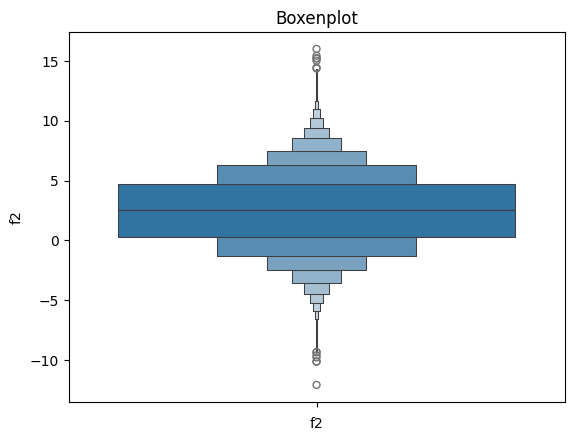

In [7]:
ax = sns.boxenplot(data=geo_data_0, y='f2')
ax.set(xlabel='f2', title='Boxenplot')

In [8]:
geo_data_0.query('f2 < -10')

,id,f0,f1,f2,product
1054,Ri3EF,-0.941260,0.293833,-12.088328,25.069622
88795,9HGRF,1.246781,-0.489114,-10.138341,94.799559
89189,qcsmH,1.183733,-0.602257,-10.138171,60.143031


Да, есть слегка выделяющиеся значения, но не зная природу параметров не можем оценить ошибочные это данные или нет.

---

In [9]:
check(geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


[Text(0.5, 1.0, 'Boxenplot')]

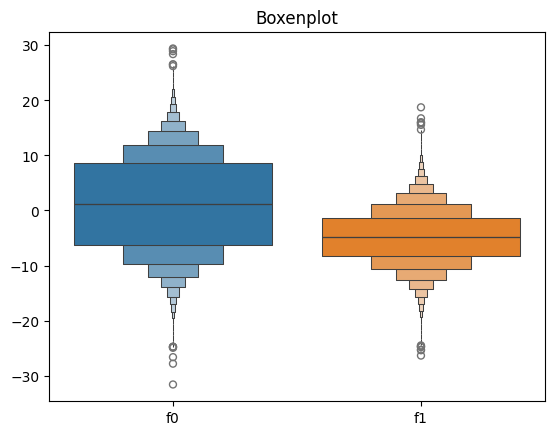

In [10]:
ax = sns.boxenplot(data=geo_data_1.drop(columns=['product','f2']))
ax.set(title='Boxenplot')

С виду тоже все хорошо.



---

In [11]:
check(geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


[Text(0.5, 1.0, 'Boxenplot')]

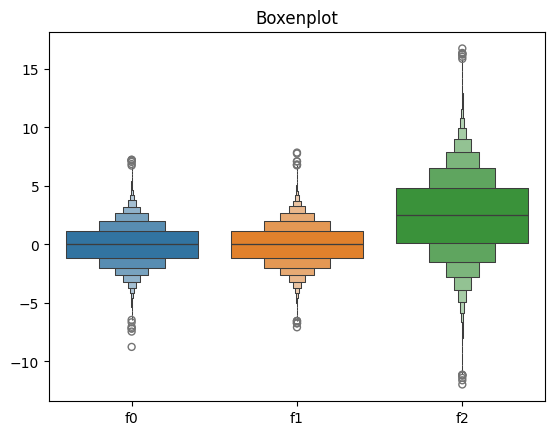

In [12]:
ax = sns.boxenplot(data=geo_data_2.drop(columns=['product']))
ax.set(title='Boxenplot')

Тоже распредлены без резких отличий.

<font color='blue'><b>Вывод по разделу 1.1 </b></font>

Подключили библиотеки, настроили ноутбук и загрузкили данные. Данных немного поэтому изучили их сразу, ярких выбросов в показателях f1,f2,f3 нигде не было.

### Исследовательский и корреляционный анализ

В данном разделе исследуем зависимости между признаками и оценим, что больше всего влияет на целевой признак - product.
На первом этапе изучим сам product

In [13]:
def corr_sct(df):
    corr = df.drop('id', axis=1).corr()
    sns.heatmap(
        corr, 
        annot=True, 
        cmap='coolwarm'
    )
    sns.pairplot(
        df.drop('id', axis=1),
        diag_kind='kde',
        plot_kws={'alpha':0.5, 'edgecolor':'w'},
        height=4,
        aspect=1,
        corner=True
    )
    plt.figure(figsize=(10,8))

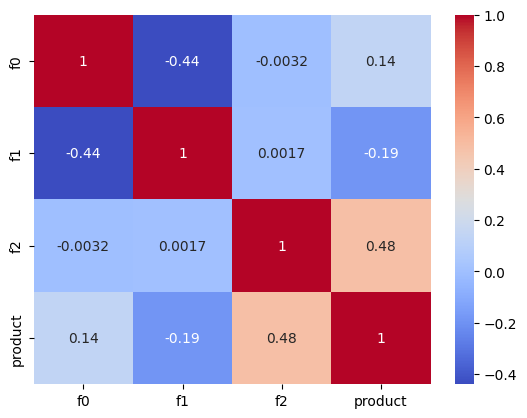

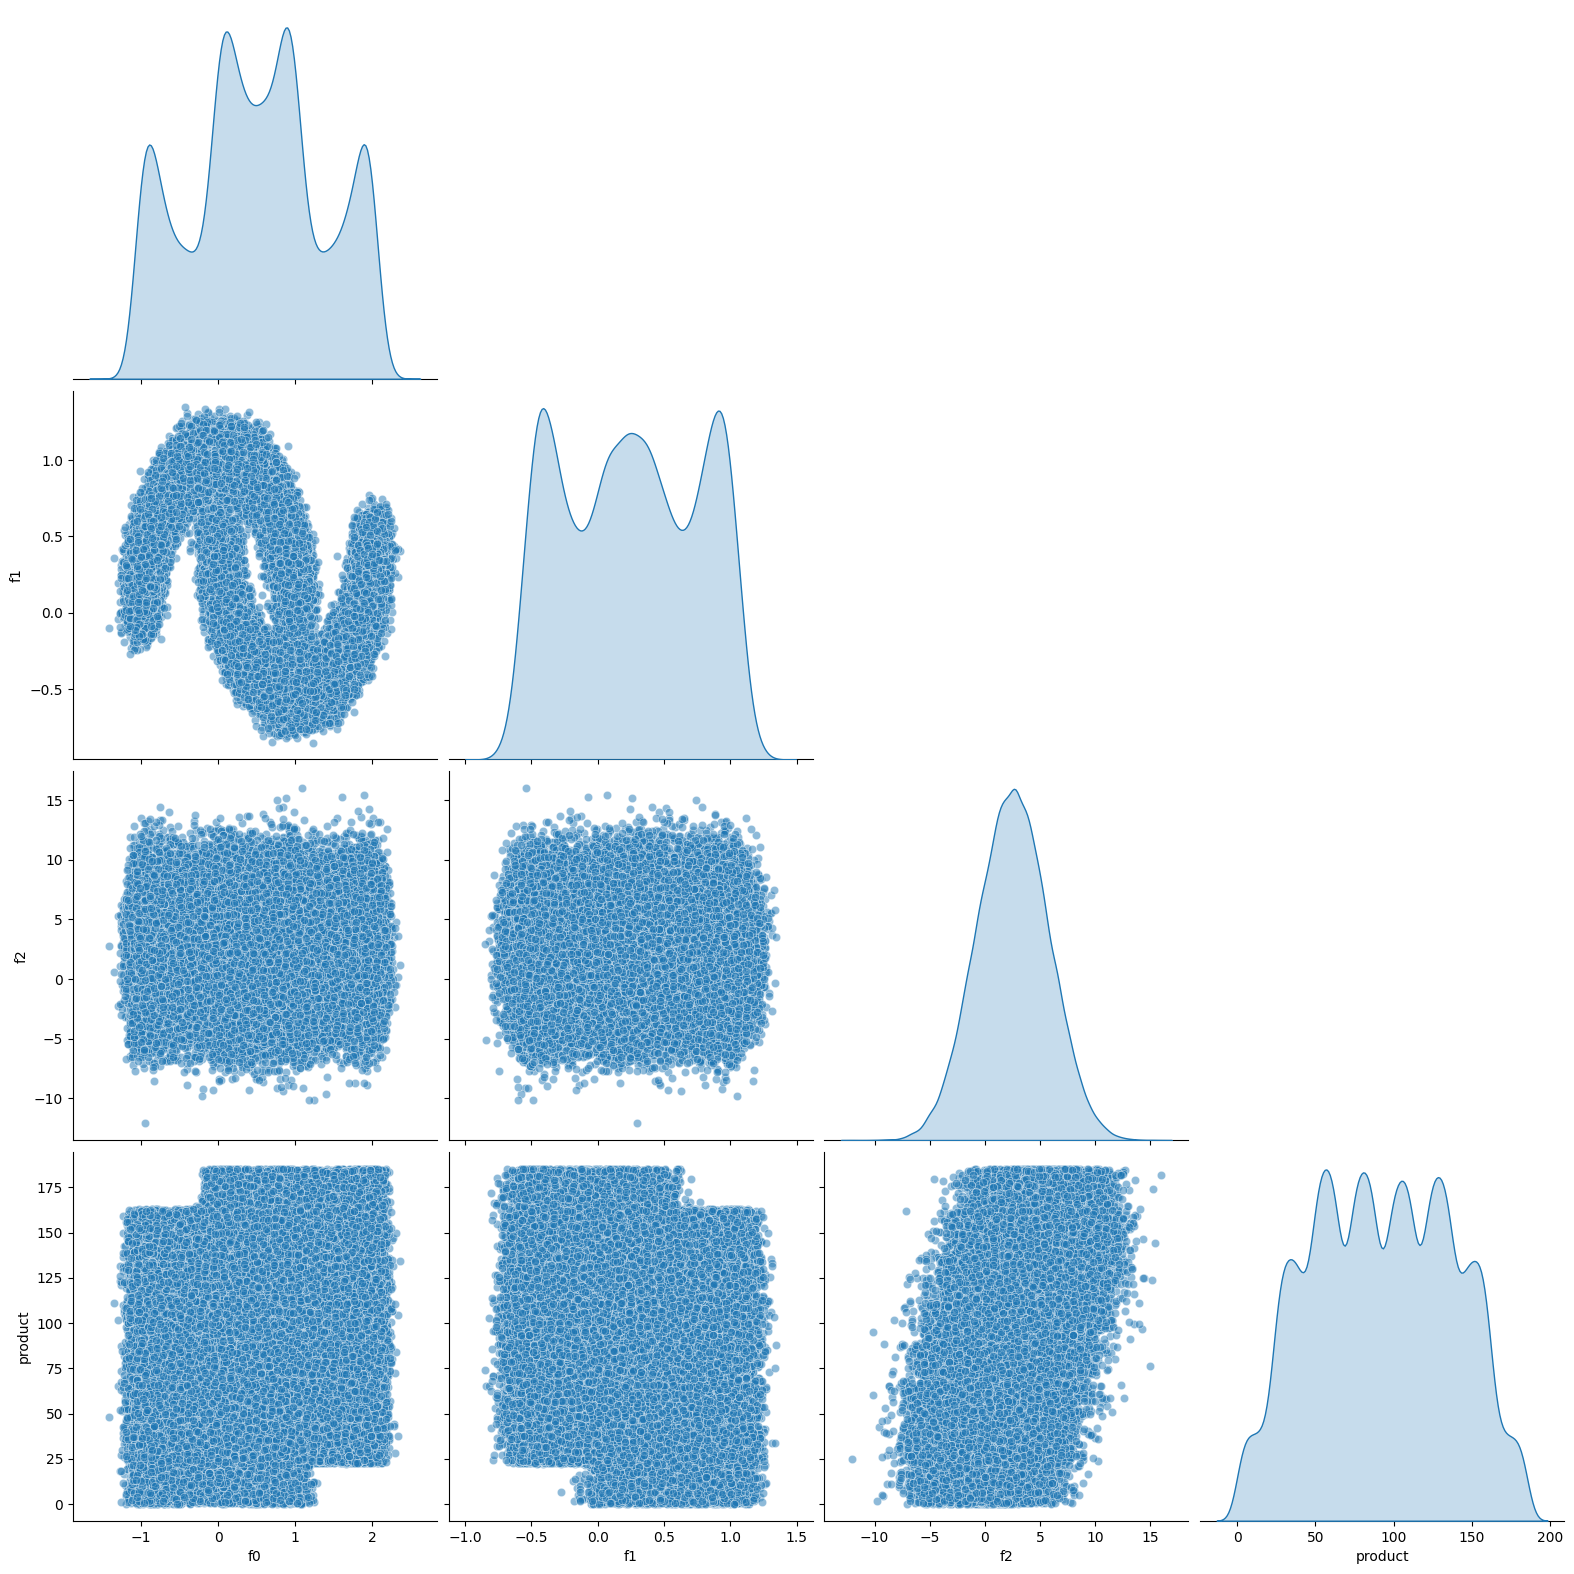

<Figure size 1000x800 with 0 Axes>

In [14]:
corr_sct(geo_data_0)

На первый взгляд, хоть какое-то влияение на целевой признак оказывает только f2, у f1 и f0 интересная зависимость в виде двух U-образных кривых.

Наблюдается мультимамодальное распредление целевого признака.

---

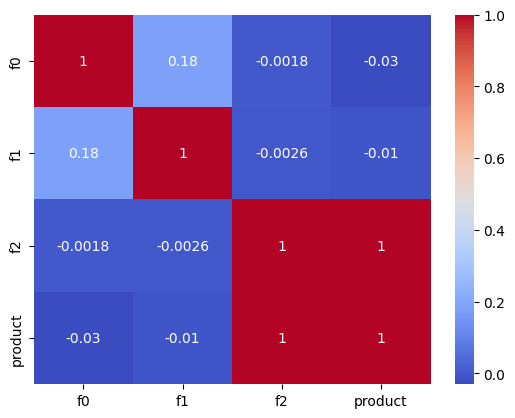

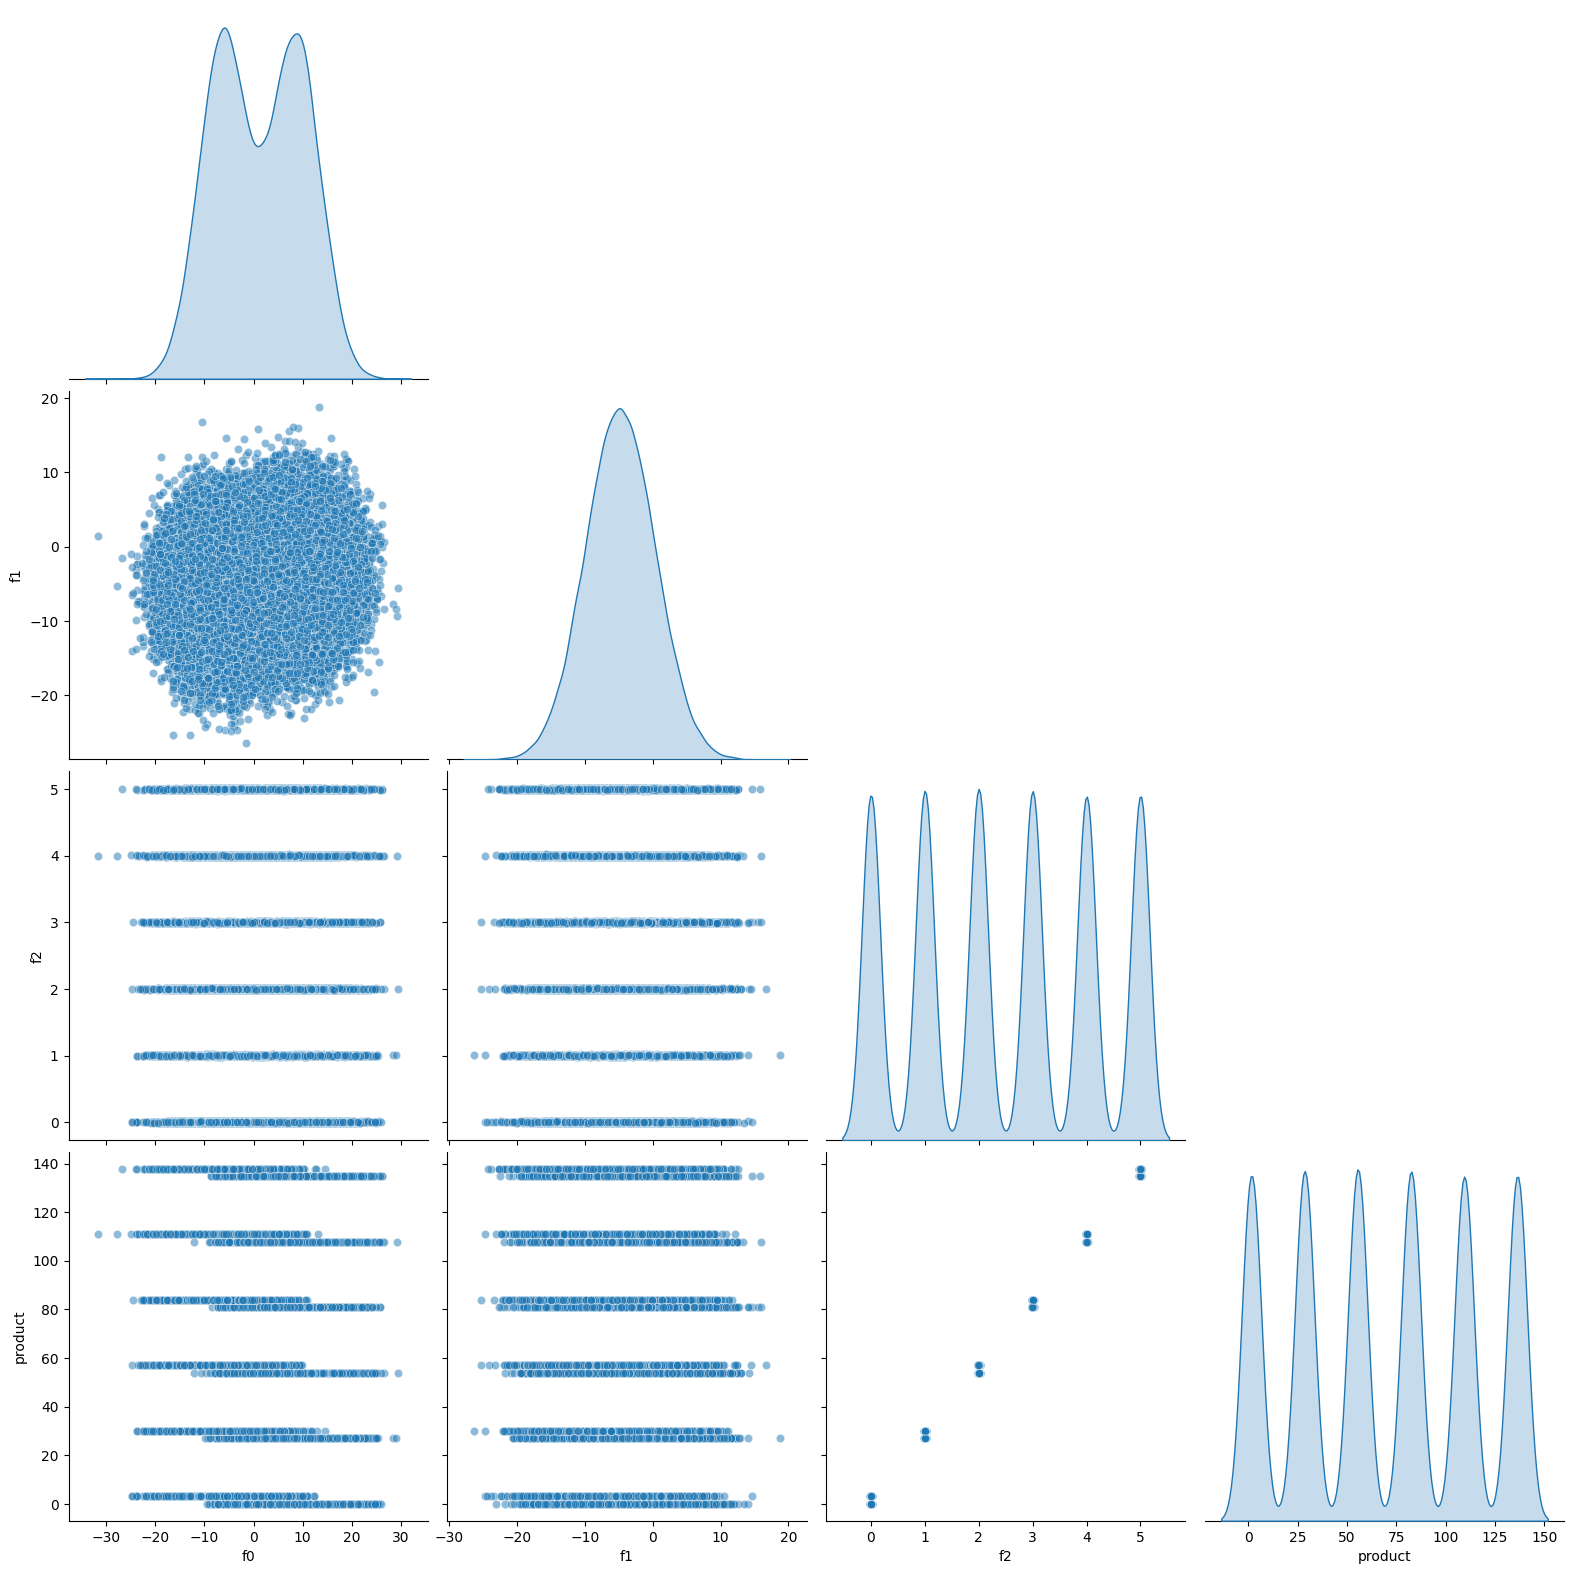

<Figure size 1000x800 with 0 Axes>

In [15]:
corr_sct(geo_data_1)

Корреляция целевого признака и f2 = 1 - это конечно плохо, но по условию задания все признаки важны, поэтому удалять мы не можем.

---

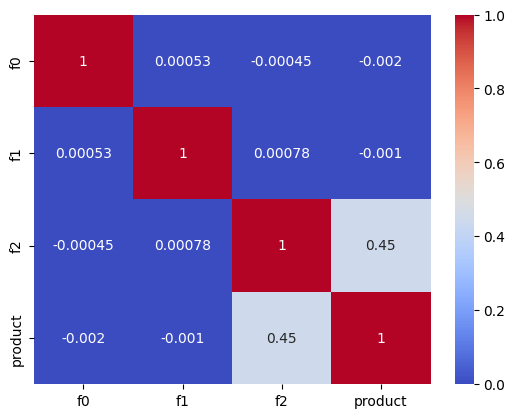

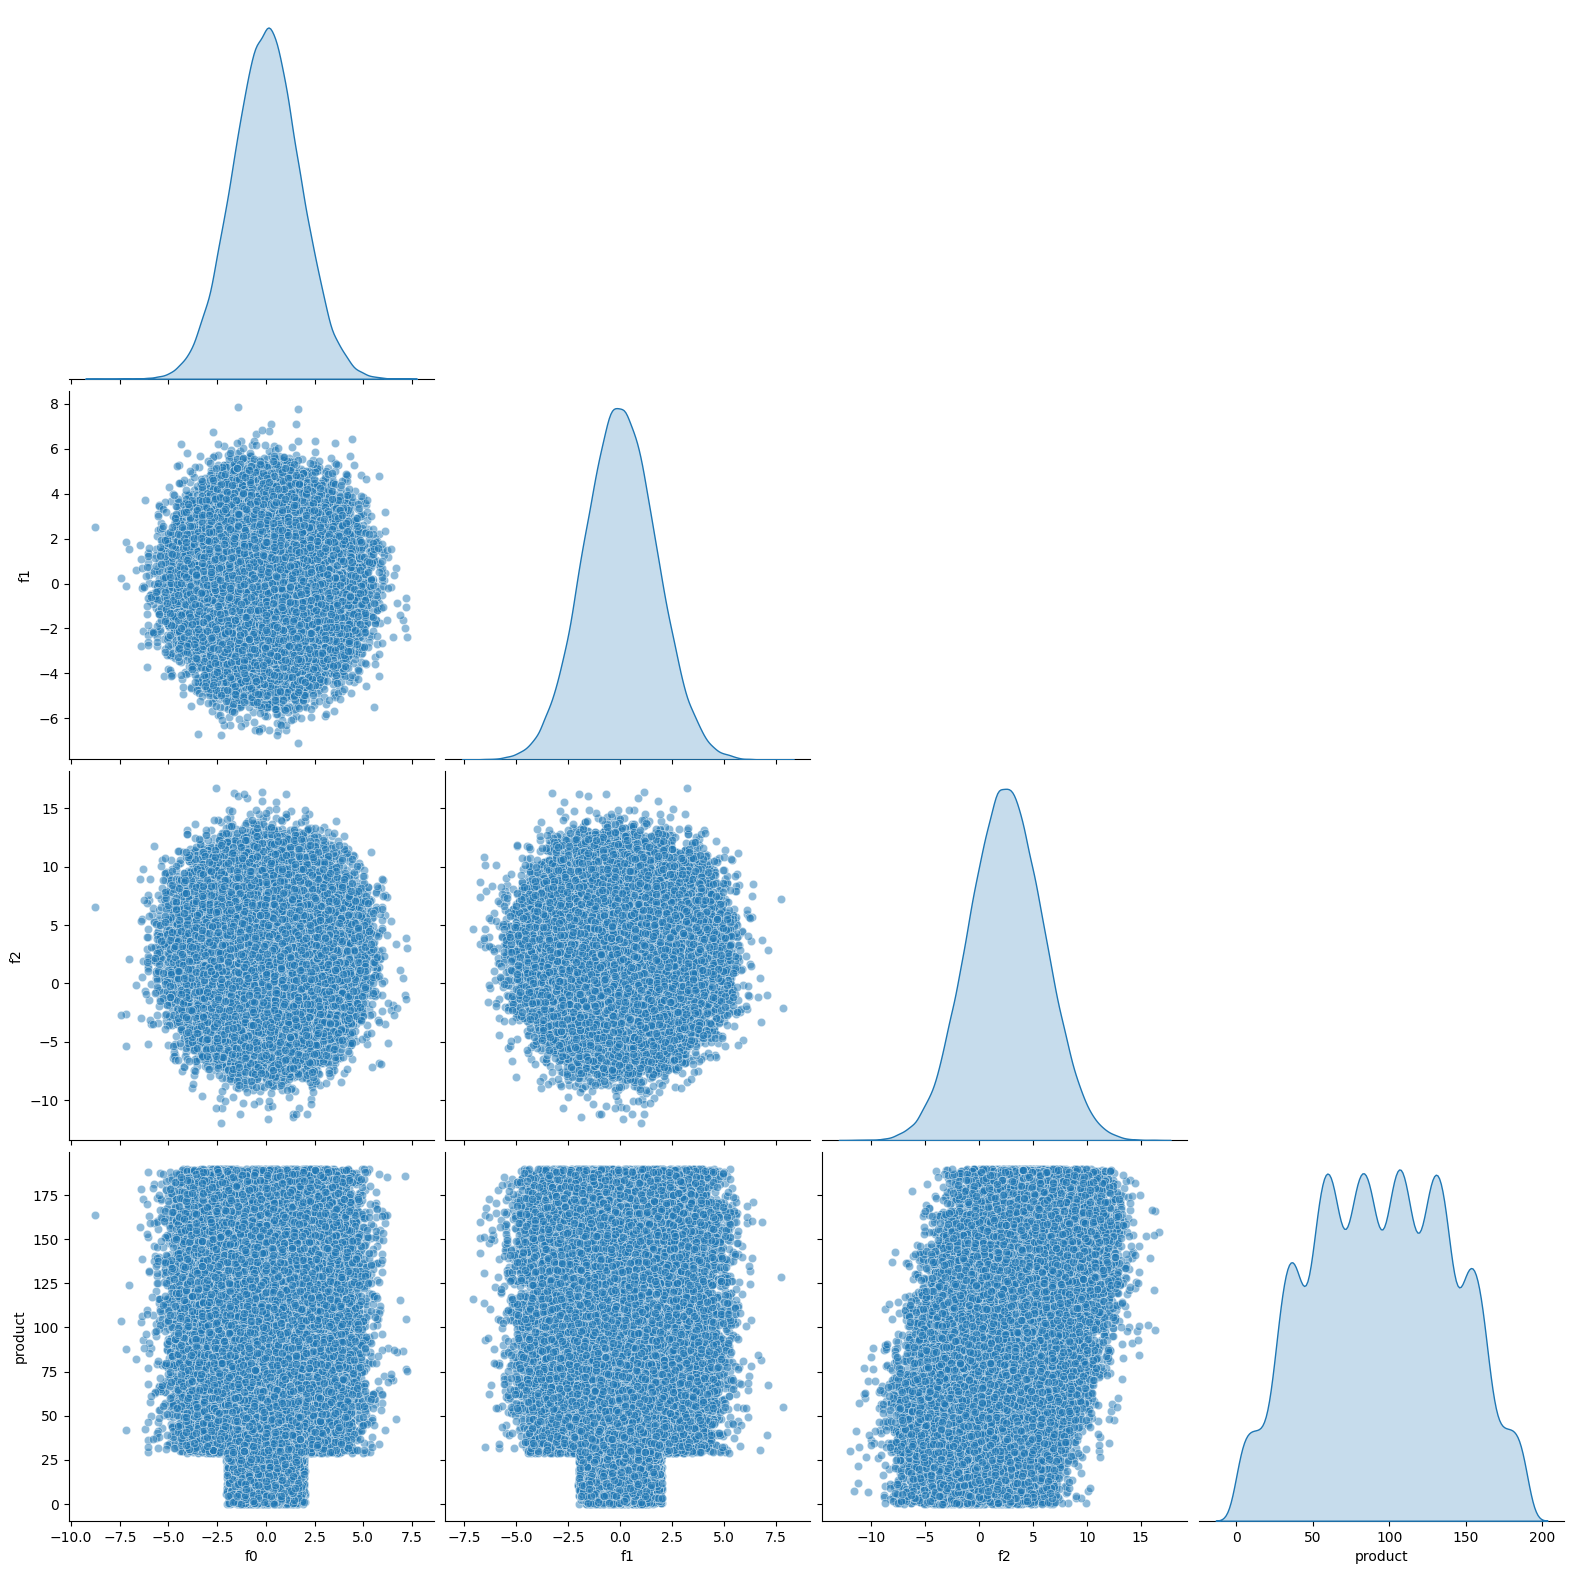

<Figure size 1000x800 with 0 Axes>

In [16]:
corr_sct(geo_data_2)

<font color='blue'><b>Вывод по разделу 1.2. </b></font>

Изучили все данные, стоит отметить, что зависимости везде разные, распредления сильно отличаются. Наибольшее влияние на таргет имеет f2. 

## Обучение и проверка модели

Как и сказано в условиях будем использовать линейную регрессию. Оценивать ее качество будем среднеквадратичным отклонением, потому что он подходит для данной ситуации - данные непрерывные, равномерные, а значит отклонение от расчетного истинного отлично продемонстирует качество.

In [17]:
RESERCH_POINT = 500  # Количество скважин для выборки
BEST_POINTS = 200  # Количество лучших скважин
BOOTSTRAP_SAMPLES = 1000  # Количество бутстрэп-выборок
BUDGET = 10_000_000_000  # Бюджет на разработку 200 скважин (в рублях)
REVENUE_PER_UNIT = 450_000  # Доход с 1 тыс. баррелей (в рублях)
PROB_LOSS = 0.025  # Для 95%-го доверительного интервала (2.5% и 97.5%)

In [18]:
def model_linear(df, name):

    X_train, X_val, y_train, y_val = train_test_split(
        df.drop(columns='product'),
        df['product'],
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE
    )
    model = LinearRegression()
    model.fit(X_train.drop(columns='id'), y_train)
    pred = model.predict(X_val.drop(columns='id'))
    df_target_predict = pd.DataFrame({
        f'pred_{name}': pred,
        f'target_{name}': y_val.values
    })
    
    mean_pred = pred.mean()
    rmse = root_mean_squared_error(y_val, pred)
    print(f'Для региона {name}:')
    print(f'Средний запас предсказанного сырья: {mean_pred:.2f} тыс. баррелей')
    print(f'RMSE модели: {rmse:.2f} тыс. баррелей')
    print(f'Анализ: RMSE составляет {rmse / mean_pred * 100:.2f}% от среднего предсказания. Это указывает на {("высокую" if rmse / mean_pred > 0.2 else "приемлемую")} точность модели.')
    
    return df_target_predict

In [19]:
list_profit = []
reg_names = ['reg_1', 'reg_2', 'reg_3']
df_target_predict_all = pd.DataFrame()

zones = [
    (geo_data_0, 'reg_1'), 
    (geo_data_1, 'reg_2'), 
    (geo_data_2, 'reg_3')
]

for zon, name_zone in zones:
    print((model_linear(zon, name_zone).head()))

Для региона reg_1:
Средний запас предсказанного сырья: 92.43 тыс. баррелей
RMSE модели: 37.56 тыс. баррелей
Анализ: RMSE составляет 40.64% от среднего предсказания. Это указывает на высокую точность модели.
   pred_reg_1  target_reg_1
0   82.780945     82.940945
1   41.891741     43.963568
2  137.356107    125.408598
3  105.695487     98.067233
4   99.545704     64.533441
Для региона reg_2:
Средний запас предсказанного сырья: 68.80 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей
Анализ: RMSE составляет 1.30% от среднего предсказания. Это указывает на приемлемую точность модели.
   pred_reg_2  target_reg_2
0   53.253264     53.906522
1  109.796493    110.992147
2   -0.244098      0.000000
3  137.133124    137.945408
4   28.252534     26.953261
Для региона reg_3:
Средний запас предсказанного сырья: 94.92 тыс. баррелей
RMSE модели: 40.10 тыс. баррелей
Анализ: RMSE составляет 42.25% от среднего предсказания. Это указывает на высокую точность модели.
   pred_reg_3  target_reg_3
0   72.536223 

<font color='blue'><b>Вывод по разделу 2. </b></font>

Получились очень разношерстные значения. 1 и 3 регион, несмотря на наибольшее предполагаемое среднее имеют и самое большое СКО. СКО равное чуть меньше половины среднего плохой результат точности. 2 регион, несмотря на не большой показатель среднего имеют низкое колебание СКО (еще бы, у нас там входной признак с высочайшей корреляцией с таргетом) - поэтому его предсказания наиболее точное.

## Подготовка к расчёту прибыли

Ключевые значения для расчётов:

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.


Бюджет на разработку скважин в регионе — 10 млрд рублей.


При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Все переменные уже объявлены выше, расчет тоже происходит выше.

In [20]:
print(f'Для того, чтобы бюджет разработку окупился необходимо добыть минимум {BUDGET / REVENUE_PER_UNIT:.2f} тыс баррелей')
print(f'Для того, чтобы бюджет разработку окупился лучшие 200 точек должны принести по {BUDGET / REVENUE_PER_UNIT/BEST_POINTS :.2f} тыс баррелей')

Для того, чтобы бюджет разработку окупился необходимо добыть минимум 22222.22 тыс баррелей
Для того, чтобы бюджет разработку окупился лучшие 200 точек должны принести по 111.11 тыс баррелей


<font color='blue'><b>Вывод по разделу 3 </b></font>

Значения везде положительные, значит везде не хватает среднего значения. В первом и третьем регионе дельта меньше (как мы помним там среднее выше), во втором дела обстоят еще хуже. Далее посмотрим детальнее, по правильному - отберем наилучшие скважены.


## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

 4.1. Выберите скважины с максимальными значениями предсказаний. 
 
 
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 
 
 
 
 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [21]:
def prof(pred, target, best_points=BEST_POINTS, bootstrap=False):
#     print(Counter(pred.index==target.index)[False])
    df = pd.DataFrame({
        'pred' : pred, 
        'target' : target
    })

    df = df.sort_values(by='pred', ascending=False)
    selected_target = df['target'][:best_points]
#     if bootstrap:
#         print(f'Размер selected_target - {selected_target.shape}')
    total_volume = selected_target.sum()
    revenue = total_volume * REVENUE_PER_UNIT
    profit = revenue - BUDGET
    return profit

In [22]:
for df, name in zones:
    df_target_predict = model_linear(df, name)
    df_target_predict_all = pd.concat([df_target_predict_all, df_target_predict], axis=1)
    profit = prof(df_target_predict[f'pred_{name}'], df_target_predict[f'target_{name}'])
    list_profit.append(profit)

result_profit_df = pd.DataFrame({
    'reg_name': reg_names,
    'profit': list_profit
})


Для региона reg_1:
Средний запас предсказанного сырья: 92.43 тыс. баррелей
RMSE модели: 37.56 тыс. баррелей
Анализ: RMSE составляет 40.64% от среднего предсказания. Это указывает на высокую точность модели.
Для региона reg_2:
Средний запас предсказанного сырья: 68.80 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей
Анализ: RMSE составляет 1.30% от среднего предсказания. Это указывает на приемлемую точность модели.
Для региона reg_3:
Средний запас предсказанного сырья: 94.92 тыс. баррелей
RMSE модели: 40.10 тыс. баррелей
Анализ: RMSE составляет 42.25% от среднего предсказания. Это указывает на высокую точность модели.


In [23]:
result_profit_df

,reg_name,profit
0,reg_1,3.424026e+09
1,reg_2,2.415087e+09
2,reg_3,2.554955e+09


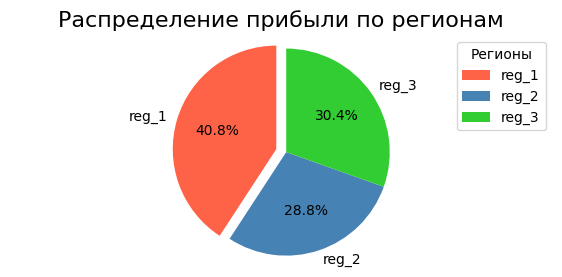

In [24]:
plt.figure(figsize=(7, 3))
plt.pie(
    result_profit_df['profit'],
    labels=result_profit_df['reg_name'],
    startangle=90,
    explode=[0.1, 0, 0],
    colors=['#FF6347', '#4682B4', '#32CD32'],
    autopct='%1.1f%%'
)
plt.title('Распределение прибыли по регионам', fontsize=16)
plt.axis('equal')
plt.legend(
    result_profit_df['reg_name'],
    title='Регионы',
    loc='upper right'
)
plt.show()

<font color='blue'><b>Вывод по разделу 4. </b></font>

На первый взгляд, каждый регион должен принести прибыль. С учетом затрат на разработку скважен первый регион принесет 3,4 млрд, третий 2,5 млрд, второй 2,4 млрд. Оценить эти данные получится в следующем разделе

## Риски и прибыль для каждого региона

Посчитайте риски и прибыль для каждого региона:


 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 
 
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 
 
 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


In [25]:
def bootstrap_analysis(predict, target, name, points=RESERCH_POINT, bootstrap_samples=BOOTSTRAP_SAMPLES):
    profits = []
    rng = np.random.default_rng(seed=RANDOM_STATE)
    
    for i in range(bootstrap_samples):
        sample_indices = rng.choice(predict.index, size=points, replace=True)
        sample_pred = predict.loc[sample_indices]
        sample_target = target.loc[sample_indices]
        profit = prof(sample_pred, sample_target, bootstrap=True)
        profits.append(profit)
    
    profits = pd.Series(profits)
    
    mean_profit = profits.mean()
    lower_bound = profits.quantile(PROB_LOSS)
    upper_bound = profits.quantile(1 - PROB_LOSS)
    risk_of_loss = (profits < 0).mean() * 100
    
    print(f'\nРегион {name}:')
    print(f'Средняя прибыль: {mean_profit / 1_000_000:.2f} млн руб.')
    print(f'95%-й доверительный интервал: от {lower_bound / 1_000_000:.2f} до {upper_bound / 1_000_000:.2f} млн руб.')
    print(f'Риск убытков: {risk_of_loss:.2f}%')
    
    return mean_profit, lower_bound, upper_bound, risk_of_loss

In [26]:
mean_profit = []
list_low = []
list_up = []
risk = []
res_geo = pd.DataFrame()

results = {}

for name in reg_names:
    mean_p, low, up, risk_p = bootstrap_analysis(
        df_target_predict_all[f'pred_{name}'],
        df_target_predict_all[f'target_{name}'],
        name
    )
    
    mean_profit.append(mean_p)
    list_low.append(low)
    list_up.append(up)
    risk.append(risk_p)
    res_geo[f'profit_{name}'] = pd.Series([prof(df_target_predict_all[f'pred_{name}'], 
                                                df_target_predict_all[f'target_{name}']) 
                                           for _ in range(BOOTSTRAP_SAMPLES)])
res = pd.DataFrame({
    'region' : ['reg_1', 'reg_2', 'reg_3'],
    'mean' : mean_profit,
    'low' : list_low,
    'up' : list_up,
    'risk_of_loss': risk}
)


Регион reg_1:
Средняя прибыль: 382.50 млн руб.
95%-й доверительный интервал: от -120.59 до 884.03 млн руб.
Риск убытков: 7.60%

Регион reg_2:
Средняя прибыль: 421.77 млн руб.
95%-й доверительный интервал: от 10.83 до 818.76 млн руб.
Риск убытков: 2.40%

Регион reg_3:
Средняя прибыль: 348.49 млн руб.
95%-й доверительный интервал: от -213.69 до 866.06 млн руб.
Риск убытков: 10.50%


In [27]:
df_target_predict_all.head()

,pred_reg_1,target_reg_1,pred_reg_2,target_reg_2,pred_reg_3,target_reg_3
0,82.780945,82.940945,53.253264,53.906522,72.536223,77.366205
1,41.891741,43.963568,109.796493,110.992147,66.579868,40.588032
2,137.356107,125.408598,-0.244098,0.000000,80.751463,57.820983
3,105.695487,98.067233,137.133124,137.945408,97.802814,89.209380
4,99.545704,64.533441,28.252534,26.953261,113.885918,120.450829


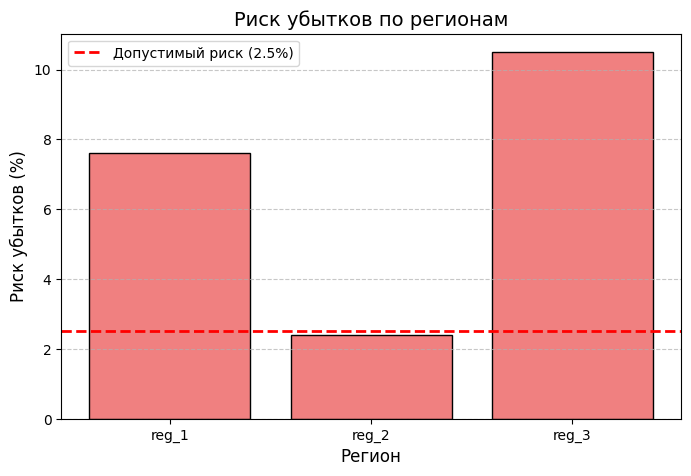

In [28]:
plt.figure(figsize=(8, 5))
bars = plt.bar(res['region'], res['risk_of_loss'], color='lightcoral', edgecolor='black')
plt.axhline(y=2.5, color='red', linestyle='--', linewidth=2, label='Допустимый риск (2.5%)')

plt.title('Риск убытков по регионам', fontsize=14)
plt.xlabel('Регион', fontsize=12)
plt.ylabel('Риск убытков (%)', fontsize=12)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)


<font color='blue'><b>Вывод по разделу 5. </b></font>

Табличные данные, и данные графиков подтверждают, что лучший выбор для работы - регион 2. У него минимальные показатели доли риска в % (единственный соответствует требуемому значению не более 2.5%), а так же максимальное значение возможной выгоды в доверительном интервале 95%. По графику у него самая нормальная плотность распредления, конечно убыток превышает плотность других гео-точек, но потенциальная выгода намного больше опережиает две другие точки.

## Выводы

Для выбора оптимального региона для бурения новой скважины в компании «ГлавРосГосНефть» был проведён комплексный анализ трёх регионов на основе данных геологоразведки. Данные были загружены и проверены, ярких выбросов в признаках не обнаружено, что позволило приступить к моделированию. Для каждого региона была построена модель линейной регрессии, так как она единственная подходит для задачи из-за предсказуемости. Данные разделили на обучающую и валидационную выборки в соотношении 75:25, обучили модели и получили предсказания объёмов запасов нефти. Анализ показал, что регионы 1 и 3 имеют высокое среднее предсказанное значение запасов, но сопровождаются значительным стандартным отклонением (RMSE), указывающим на низкую точность предсказаний. В то же время регион 2, несмотря на меньшее среднее значение запасов, демонстрирует наименьшее RMSE благодаря высокой корреляции признака f2 с целевой переменной, что делает его предсказания наиболее точными.

Для расчёта прибыли были определены ключевые параметры: бюджет на разработку 10 млрд рублей, доход 450 тыс. рублей за тысячу баррелей. Рассчитанный минимальный объём сырья для безубыточной разработки превышает средние запасы во всех регионах, что подчёркивает необходимость выбора скважин с максимальными предсказанными запасами. Функция прибыли была реализована для выбора 200 лучших скважин из 500 исследованных в каждом регионе, с учётом затрат и доходов. Первичные расчёты показали потенциальную прибыль: 3.4 млрд рублей для региона 1, 2.4 млрд для региона 2 и 2.5 млрд для региона 3. 

Техника Bootstrap с 1000 выборок позволила оценить распределение прибыли, среднюю прибыль, 95%-й доверительный интервал и риск убытков. Регион 2 выделился как единственный, удовлетворяющий условию риска убытков менее 2.5%, с минимальной вероятностью убытков и наибольшей средней прибылью среди допустимых регионов. Его распределение прибыли, несмотря на меньшую плотность убыточных сценариев, демонстрирует более высокую потенциальную выгоду по сравнению с регионами 1 и 3, где риски превышают допустимый порог.

На основании анализа рекомендуется выбрать **регион 2** для разработки скважин, так как он сочетает минимальный риск убытков и максимальную среднюю прибыль, обеспечивая наибольшую финансовую стабильность и потенциал в рамках заданных бизнес-условий.